In [31]:
import torch
from diffusers import AutoencoderKL
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

In [32]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = [
            os.path.join(image_folder, fname) for fname in os.listdir(image_folder)
            if fname.endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return image

image_transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to range [-1, 1]
])

image_folder = "images/train"
dataset = ImageDataset(image_folder, image_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [41]:
def train_vae_step(vae, pixel_values):
    device = pixel_values.device

    vae.to(pixel_values.dtype)

    latents = vae.encode(pixel_values).latent_dist.sample() 

    reconstructed_images = vae.decode(latents).sample

    reconstructed_images = torch.clamp(reconstructed_images, min=-1.0, max=1.0)

    loss = torch.nn.functional.mse_loss(reconstructed_images, pixel_values)

    return loss


In [76]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f"./logs/{current_time}"

writer = SummaryWriter(log_dir=log_dir)

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to("cuda")
vae.train()

# Freeze all parameters
for param in vae.parameters():
    param.requires_grad = False

# Unfreeze the last layer of the decoder
last_layer = list(vae.decoder.children())[-1]
for param in last_layer.parameters():
    param.requires_grad = True


vae.to(torch.float32)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-6)

epochs = 5
global_step = 0  

for epoch in range(epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")

    for step, pixel_values in enumerate(progress_bar):
        pixel_values = pixel_values.to("cuda").to(torch.float32)

        with torch.cuda.amp.autocast():
            loss = train_vae_step(vae, pixel_values)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar("Loss/train", loss.item(), global_step)

        progress_bar.set_postfix({"Loss": loss.item()})

        global_step += 1  # Increment global step for TensorBoard logging

print("VAE Fine-Tuning Complete!")

writer.close()


Epoch 1/5:   2%|▏         | 314/14726 [00:06<04:21, 55.05batch/s, Loss=0.00399] /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/5: 100%|██████████| 14726/14726 [04:44<00:00, 51.85batch/s, Loss=0.00249] 

VAE Fine-Tuning Complete!


In [77]:
torch.save(vae.state_dict(), "./findetuned_sd_vae_v1.pth")

In [71]:
def train_vae_step_single(vae, pixel_values, gt):
    device = pixel_values.device

    vae.to(pixel_values.dtype)

    latents = vae.encode(pixel_values).latent_dist.sample() 

    reconstructed_images = vae.decode(latents).sample

    reconstructed_images = torch.clamp(reconstructed_images, min=-1.0, max=1.0)

    loss = torch.nn.functional.mse_loss(reconstructed_images, gt)

    return loss


from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm

image_path1 = "images/train/5.png"
image_path2 = "images/train/6.png"

# Load an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Load and convert to RGB
    return image

image1 = load_image(image_path1)
image2 = load_image(image_path2)

processed_image1 = image_transform(image1).unsqueeze(0).to("cuda")
processed_image2 = image_transform(image2).unsqueeze(0).to("cuda")

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f"./logs/{current_time}"

writer = SummaryWriter(log_dir=log_dir)

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to("cuda")
vae.train()

# Freeze the decoder
for param in vae.decoder.parameters():
    param.requires_grad = False


vae.to(torch.float32)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

epochs = 10
global_step = 0  

for epoch in range(epochs):
    with torch.cuda.amp.autocast():
        loss = train_vae_step_single(vae, processed_image1, processed_image2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    writer.add_scalar("Loss/train", loss.item(), global_step)

    global_step += 1  # Increment global step for TensorBoard logging
    print(f"[Epoch: {epoch}] Loss/train", loss.item())

print("VAE Fine-Tuning Complete!")



[Epoch: 0] Loss/train 0.49524301290512085
[Epoch: 1] Loss/train 0.4952472448348999
[Epoch: 2] Loss/train 0.4952464997768402
[Epoch: 3] Loss/train 0.49524450302124023
[Epoch: 4] Loss/train 0.4952468276023865
[Epoch: 5] Loss/train 0.49524426460266113
[Epoch: 6] Loss/train 0.4952462315559387
[Epoch: 7] Loss/train 0.4952470064163208
[Epoch: 8] Loss/train 0.49524664878845215
[Epoch: 9] Loss/train 0.49524539709091187
VAE Fine-Tuning Complete!


In [75]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f"./logs/{current_time}"

writer = SummaryWriter(log_dir=log_dir)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

epochs = 100
global_step = 0  

for epoch in range(epochs):
    with torch.cuda.amp.autocast():
        loss = train_vae_step_single(vae, processed_image1, processed_image2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    writer.add_scalar("Loss/train", loss.item(), global_step)

    global_step += 1  # Increment global step for TensorBoard logging
    print(f"[Epoch: {epoch}] Loss/train", loss.item())

print("VAE Fine-Tuning Complete!")
writer.close()

[Epoch: 0] Loss/train 0.4952452778816223
[Epoch: 1] Loss/train 0.4952472448348999
[Epoch: 2] Loss/train 0.4952475428581238
[Epoch: 3] Loss/train 0.4952477812767029
[Epoch: 4] Loss/train 0.4952448606491089
[Epoch: 5] Loss/train 0.49524807929992676
[Epoch: 6] Loss/train 0.4952476918697357
[Epoch: 7] Loss/train 0.49524641036987305
[Epoch: 8] Loss/train 0.4952457845211029
[Epoch: 9] Loss/train 0.49524450302124023
[Epoch: 10] Loss/train 0.4952469766139984
[Epoch: 11] Loss/train 0.4952443540096283
[Epoch: 12] Loss/train 0.4952476918697357
[Epoch: 13] Loss/train 0.49524664878845215
[Epoch: 14] Loss/train 0.49524760246276855
[Epoch: 15] Loss/train 0.4952446222305298
[Epoch: 16] Loss/train 0.49524766206741333
[Epoch: 17] Loss/train 0.49524733424186707
[Epoch: 18] Loss/train 0.4952465891838074
[Epoch: 19] Loss/train 0.4952471852302551
[Epoch: 20] Loss/train 0.4952445924282074
[Epoch: 21] Loss/train 0.4952455759048462
[Epoch: 22] Loss/train 0.4952462315559387
[Epoch: 23] Loss/train 0.495244503021

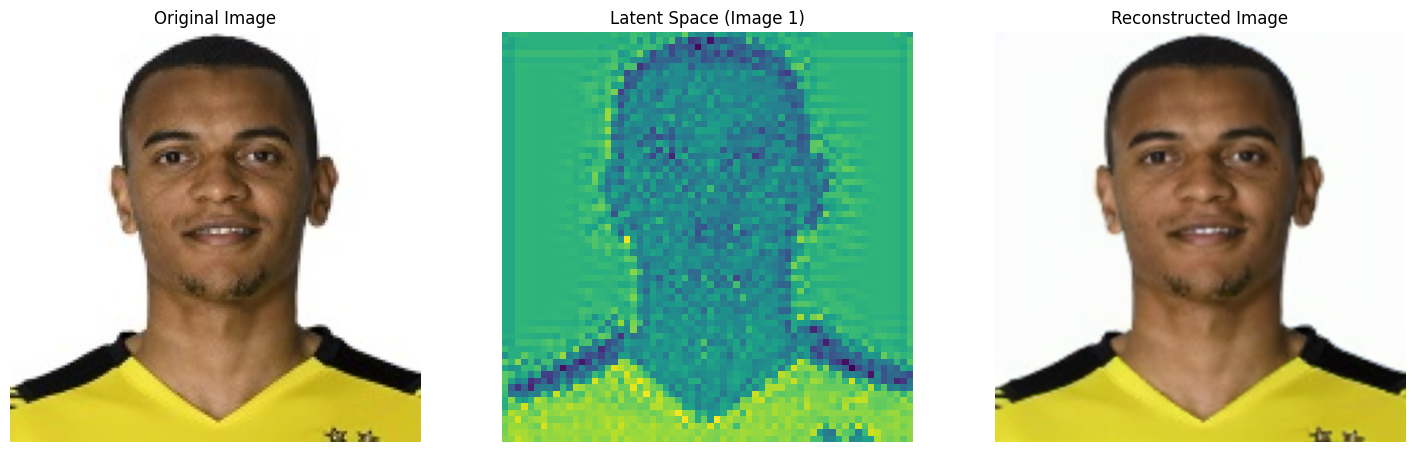

In [70]:
import torch
from diffusers import AutoencoderKL
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained VAE
vae_infer = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae_infer.to("cuda").eval()  # Move to GPU and set to evaluation mode

# Define image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to match VAE input size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Load and convert to RGB
    return image

# Visualize images and latent spaces
def visualize_images(original, latent, reconstructed, latent_title="Latent Space"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(latent, cmap="viridis")
    axes[1].set_title(latent_title)
    axes[1].axis("off")

    axes[2].imshow(reconstructed)
    axes[2].set_title("Reconstructed Image")
    axes[2].axis("off")

    plt.show()

def encode_decode_blend(image_path1, alpha=0.5):
    image1 = load_image(image_path1)
    processed_image1 = image_transform(image1).unsqueeze(0).to("cuda")

    with torch.no_grad():
        latent1 = vae.encode(processed_image1).latent_dist.sample()

        latent1_vis = latent1.squeeze().cpu().numpy().mean(axis=0)  # Average across channels

        reconstructed_image1 = vae.decode(latent1).sample[0]


    # Post-process images for visualization
    def postprocess_image(img):
        img = (img.clamp(-1, 1) + 1) / 2  # De-normalize to [0, 1]
        return img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC

    reconstructed_image1 = postprocess_image(reconstructed_image1)

    # Visualize results
    visualize_images(image1, latent1_vis, reconstructed_image1, "Latent Space (Image 1)")

# Example usage: Replace with paths to your footballer images
image_path1 = "images/train/5.png"
encode_decode_blend(image_path1, alpha=0.5)


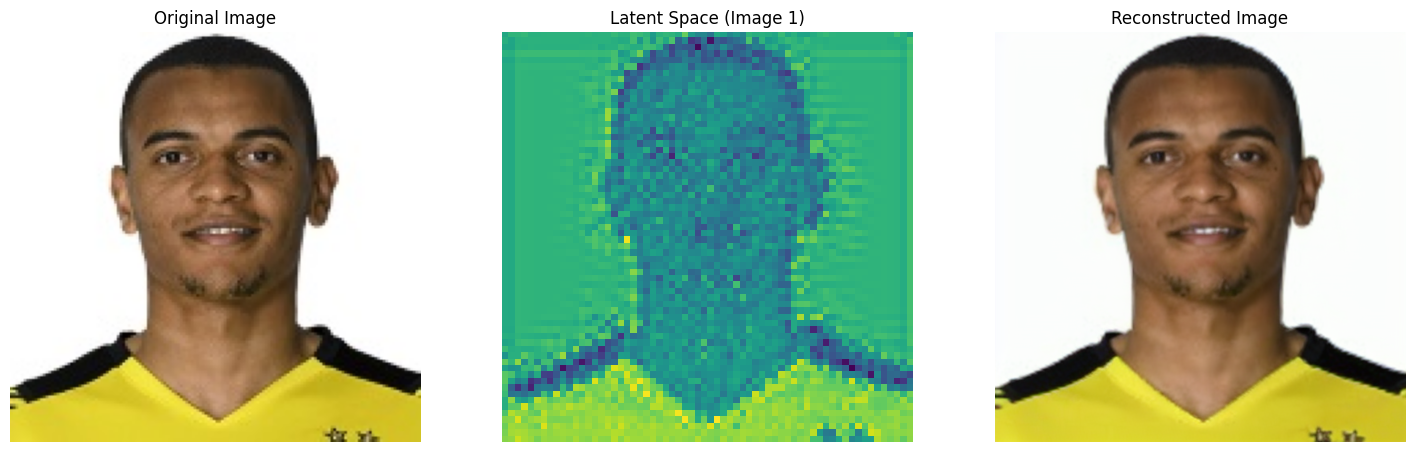

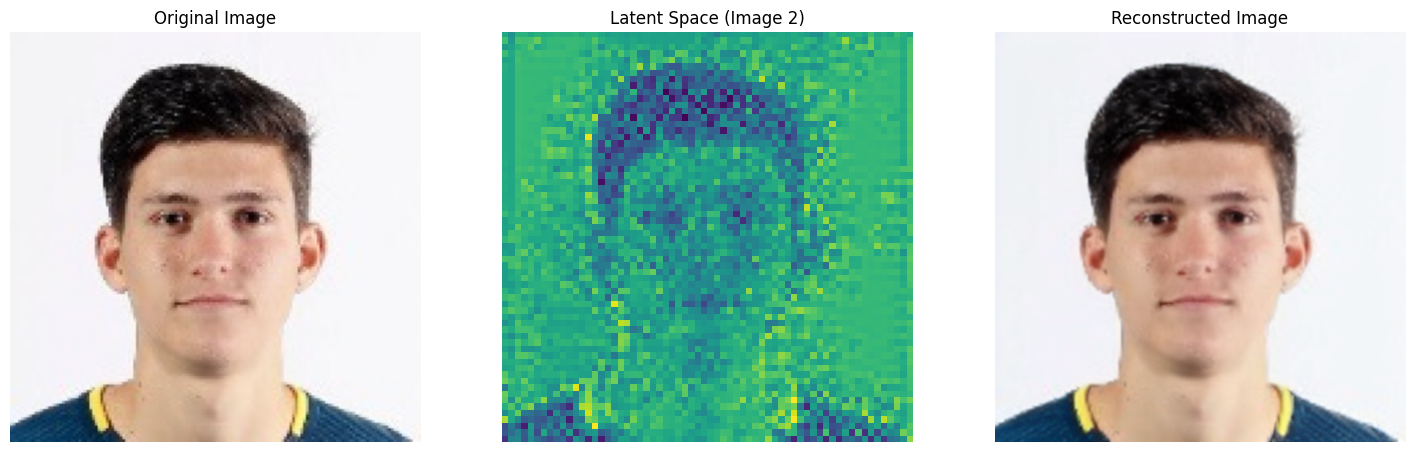

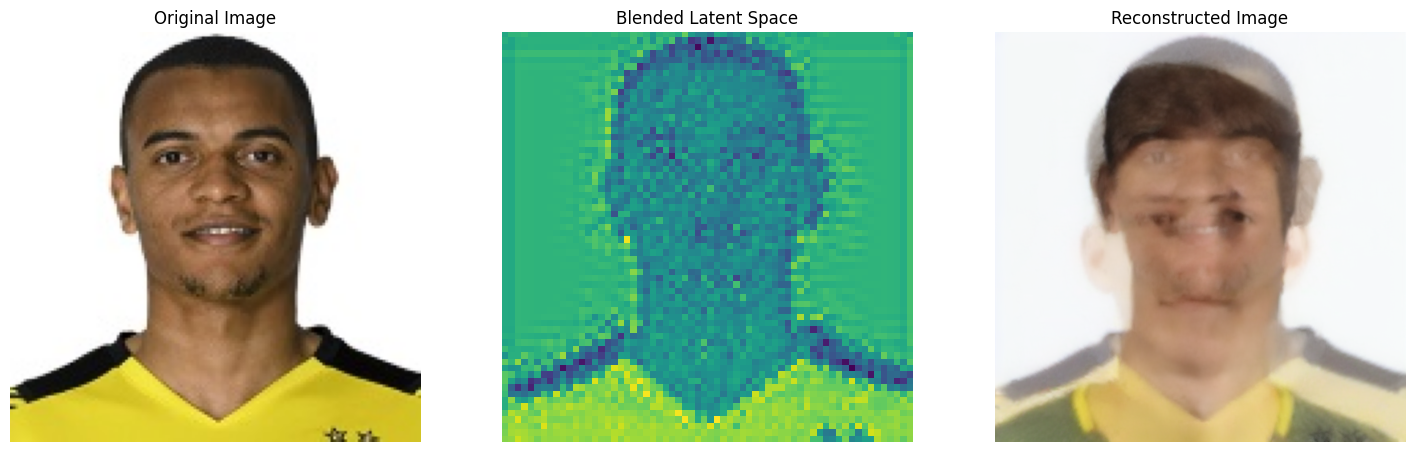

In [61]:
import torch
from diffusers import AutoencoderKL
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained VAE
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to("cuda").eval()  # Move to GPU and set to evaluation mode

# Define image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to match VAE input size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Load and convert to RGB
    return image

# Visualize images and latent spaces
def visualize_images(original, latent, reconstructed, latent_title="Latent Space"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(latent, cmap="viridis")
    axes[1].set_title(latent_title)
    axes[1].axis("off")

    axes[2].imshow(reconstructed)
    axes[2].set_title("Reconstructed Image")
    axes[2].axis("off")

    plt.show()

def encode_decode_blend(image_path1, image_path2, alpha=0.5):
    image1 = load_image(image_path1)
    image2 = load_image(image_path2)
    processed_image1 = image_transform(image1).unsqueeze(0).to("cuda")
    processed_image2 = image_transform(image2).unsqueeze(0).to("cuda")

    with torch.no_grad():
        latent1 = vae.encode(processed_image1).latent_dist.sample()
        latent2 = vae.encode(processed_image2).latent_dist.sample()

        latent1_vis = latent1.squeeze().cpu().numpy().mean(axis=0)  # Average across channels
        latent2_vis = latent2.squeeze().cpu().numpy().mean(axis=0)  # Average across channels

        reconstructed_image1 = vae.decode(latent1).sample[0]
        reconstructed_image2 = vae.decode(latent2).sample[0]

        blended_latent = alpha * latent1 + (1 - alpha) * latent2

        blended_latent = (blended_latent - blended_latent.mean()) / blended_laten.std()

        blended_image = vae.decode(blended_latent).sample[0]

    # Post-process images for visualization
    def postprocess_image(img):
        img = (img.clamp(-1, 1) + 1) / 2  # De-normalize to [0, 1]
        return img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC

    reconstructed_image1 = postprocess_image(reconstructed_image1)
    reconstructed_image2 = postprocess_image(reconstructed_image2)
    blended_image = postprocess_image(blended_image)

    # Visualize results
    visualize_images(image1, latent1_vis, reconstructed_image1, "Latent Space (Image 1)")
    visualize_images(image2, latent2_vis, reconstructed_image2, "Latent Space (Image 2)")
    visualize_images(image1, latent1_vis, blended_image, "Blended Latent Space")

# Example usage: Replace with paths to your footballer images
image_path1 = "images/train/5.png"
image_path2 = "images/train/6.png"
encode_decode_blend(image_path1, image_path2, alpha=0.5)
